In [35]:
import torch
import matplotlib.pyplot as plt

from svetlanna import elements
from svetlanna import SimulationParameters
from svetlanna import wavefront as w
from svetlanna.units import ureg
from svetlanna import LinearOpticalSetup

from PIL import Image

## Creating numerical mesh with using `SimulationParameters` class

In [66]:
# screen size
lx = 8 * ureg.mm
ly = 8 * ureg.mm

# focal length, mm
f = 100 * ureg.mm

# wavelength, mm
wavelength = 1064 * ureg.nm

# number of nodes
Nx = 2048
Ny = 2048

# creating SimulationParameters exemplar
sim_params = SimulationParameters({
    'W': torch.linspace(-lx / 2, lx / 2, Nx),
    'H': torch.linspace(-ly / 2, ly / 2, Ny),
    'wavelength': wavelength,
})

In [67]:
# return 2d-tensors of x and y coordinates
x_grid, y_grid = sim_params.meshgrid(x_axis='W', y_axis='H')

## Creating a plane wave using `svetlanna.wavefront.plane_wave`

Let's create a plane wave that will fall on the aperture:

In [79]:
# create plane wave
incident_field = w.Wavefront.plane_wave(
    simulation_parameters=sim_params,
    distance=10 * ureg.cm,
    wave_direction=[0, 0, 1]
)

## Prepare image: converting to mask for the aperture

In this section we convert the image `phystech_logo.png` to aperture. The shape of the aperture will match the image. 

In [ ]:
# path to the image
image_path = '.\doc\phystech_logo.png'  # Замените на путь к вашему изображению

# image size
N, M = 256, 256

# Загрузка изображения
image = Image.open(image_path)

M = 256
# change image size
image_resized = image.resize((N, M))  # Размеры указываются как (ширина, высота)

# convert image to tensor
image_tensor = torch.tensor(
    data=list(image_resized.getdata()),
    dtype=torch.float64
).reshape(N, M, -1)

# normalize image tensor to [0, 1] range
if image_tensor.dtype == torch.uint8:
    image_tensor = image_tensor / 255.0

# use only one channel of the image (grayscale)
image_tensor = image_tensor[:, :, 0]

# binarize the image tensor
image_tensor = image_tensor >= 10  # Применяем бинаризацию

# Определяем координаты для вставки image_tensor в центр mask
start_x = (Nx - M) // 2
start_y = (Ny - N) // 2

mask = torch.zeros((Ny, Nx), dtype=torch.float64)

# put image_tensor in the center of the mask
mask[start_y:start_y + N, start_x:start_x + M] = image_tensor

In [81]:
aperture = elements.Aperture(simulation_parameters=sim_params, mask=mask)

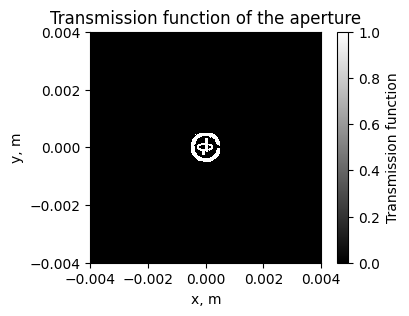

In [82]:
fig, ax = plt.subplots(figsize=(4, 3))

im = ax.pcolormesh(x_grid, y_grid, aperture.get_transmission_function(), cmap='gray')
ax.set_aspect('equal')
ax.set_xlabel('x, m')
ax.set_ylabel('y, m')
ax.set_title('Transmission function of the aperture')
fig.colorbar(im, ax=ax, label='Transmission function')

## Creating optical setup

In this section we create optical setup using `LinearOpticalSetup` class from `svetlanna.setup`. Optical setup consists of aperture with transmission function determined by `mask` tensor and thin collecting lens. Wavefront propagation calculated by `FreeSpace` element using Angular Spectrum method.

In [83]:
lens = elements.ThinLens(
    simulation_parameters=sim_params,
    focal_length=f,
    radius=100 * ureg.mm
)

free_space = elements.FreeSpace(
    simulation_parameters=sim_params,
    distance=f,
    method="AS"
)

setup = LinearOpticalSetup([aperture, free_space, lens, free_space])

## Calculating the wavefront in the back focal plane of the thin lens

As is known, a thin lens performs a Fourier transform from a wavefront incident on it. Let's compare the Fourier image created by the thin lens and Fourier image created by the Fast Fourier Transform from `torch.fft.fft2`.

In [84]:
output_wavefront = setup.forward(input_wavefront=incident_field)
output_intensity = output_wavefront.intensity

In [85]:
fft = torch.fft.fftshift(torch.fft.fft2(mask))

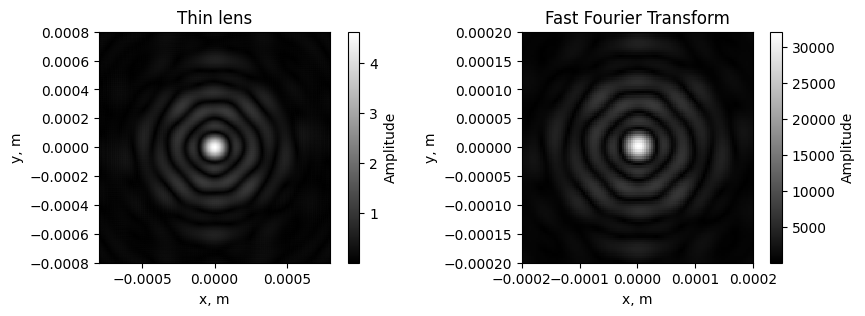

In [86]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
im0 = ax[0].pcolormesh(x_grid, y_grid, torch.sqrt(output_intensity), cmap='gray')
ax[0].set_aspect('equal')
ax[0].set_xlabel('x, m')
ax[0].set_ylabel('y, m')

ax[0].set_xlim(-lx / 10, lx / 10)
ax[0].set_ylim(-ly / 10, ly / 10)
ax[0].set_title('Thin lens')
fig.colorbar(im0, ax=ax[0], label='Amplitude')

im1 = ax[1].pcolormesh(x_grid, y_grid, torch.abs(fft), cmap='gray')
ax[1].set_aspect('equal')
ax[1].set_xlabel('x, m')
ax[1].set_ylabel('y, m')

ax[1].set_xlim(-lx / 40, lx / 40)
ax[1].set_ylim(-ly / 40, ly / 40)
ax[1].set_title('Fast Fourier Transform')
fig.colorbar(im1, ax=ax[1], label='Amplitude')